In [1]:
!unzip '/content/dataset.csv.zip' -d '/content/'

Archive:  /content/dataset.csv.zip
  inflating: /content/train.csv      


In [20]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

In [12]:
#reading the data
df=pd.read_csv('dataset.csv',parse_dates=['Dates'])
df.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [13]:
#no of unique categories
len(df['Category'].unique())

39

In [14]:
#droping these columns because the it is not present in test data, also it contains similar info as category(Target Variable)
df.drop(['Descript','Resolution'],inplace=True,axis=1)
df.head(2)

,Dates,Category,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599




**Basic EDA**

In [15]:
#checking for the missing values
df.isnull().sum()

Dates         0
Category      0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

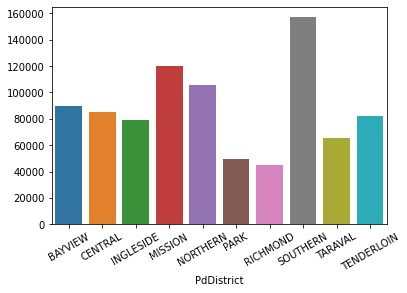

In [23]:
#checking for the crime/category distribution among each district
x=df.groupby(['PdDistrict'])['Category'].count()
gx=sb.barplot(x.index,x.values)  
plt.xticks(rotation=30)

**Southern District has most of the crime reported**

In [29]:
#doing label encoding over the categorical target variable
from sklearn.preprocessing import LabelEncoder #importing labelencoder
lb=LabelEncoder()
df['Catid']=lb.fit_transform(df['Category']) 

In [36]:
#label encoding district variable
lbl=LabelEncoder()
df['Did']=lbl.fit_transform(df['PdDistrict'])
lbl.classes_

array(['BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK',
       'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN'], dtype=object)

In [39]:
df.columns
#label encoding DayOfWeek categoricalvariable
lbl_c=LabelEncoder()
df['wday']=lbl_c.fit_transform(df['DayOfWeek'])


In [50]:
df['Block'] = df['Address'].str.contains('block', case = False)
df['ST'] = df['Address'].str.contains('ST', case = False)
df.drop(['Block','ST'],inplace=True,axis=1)

In [63]:
#feature engineering with dates columns
df['Dates']=pd.to_datetime(df['Dates'])
df['Year'] = df.Dates.dt.year
df['Month'] = df.Dates.dt.month
df['Day'] = df.Dates.dt.day
df['Hour'] = df.Dates.dt.hour
df["is_wknd"] = df.Dates.dt.weekday//4 

In [73]:

#droping the columns after feature engineering (droping address because we have lat and long)
df.drop(['Dates','Category','PdDistrict','Address'],inplace=True,axis=1)

In [75]:
df.drop(['DayOfWeek'],inplace=True,axis=1)

In [80]:
#splitting the data in train and test (77% train,33 test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     df.drop(['Catid'],axis=1),df['Catid'], test_size=0.33, random_state=42)

In [86]:
#trying a base model(DecisionTreeClassifier)
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)


DecisionTreeClassifier(random_state=0)

In [87]:
#Accuracy score on test data
clf.score(X_test, y_test)

0.22734222124055675

In [90]:
#trying random forest for the classification
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=45,min_samples_split=75 )
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=75, n_estimators=45)

In [91]:
#Accuracy score on test data
rfc.score(X_test, y_test)

0.28880751802372334

In [92]:
##Accuracy score on train data
rfc.score(X_train,y_train)

0.3552589530369272

#model is not overfitting , imbalanced data may be caused for low accuracy or we can work on creating more features

In [94]:
#Trying boosting approach
import lightgbm as lgm
trains = lgm.Dataset(X_train, label = y_train, categorical_feature=['Did', 'Month','Year','Day','Hour','is_wknd'])
params = {
    'boosting':'gbdt',
    'objective':'multiclass',
    'num_class':39,
    'max_delta_step':0.9,
    'min_data_in_leaf': 20,
    'learning_rate': 0.4,
    'max_bin': 480,
    'num_leaves': 45,
    'verbose' : 1
}
model = lgm.train(params, trains, 120)
rfc_pred=model.predict(X_test)

In [113]:
from sklearn.metrics import accuracy_score


In [107]:
#conveting the class prob score to class using argmax func
pred_class=[]
for i in rfc_pred:
  pred_class.append(np.argmax(i))
pred_cl=np.array(pred_class)


In [108]:
print ("Test Accuracy: ", accuracy_score(y_test, pred_cl))

Test Accuracy:  0.2837135944946973


**Even after using Gradient , Accuracy score remains more or less same**

## Scope of Improvement:


1.   Dataset imbalance can be reduced
2.   More feaures can be created using current features
3. Deep Learning approach can be tried



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text major ticklabel objects>)

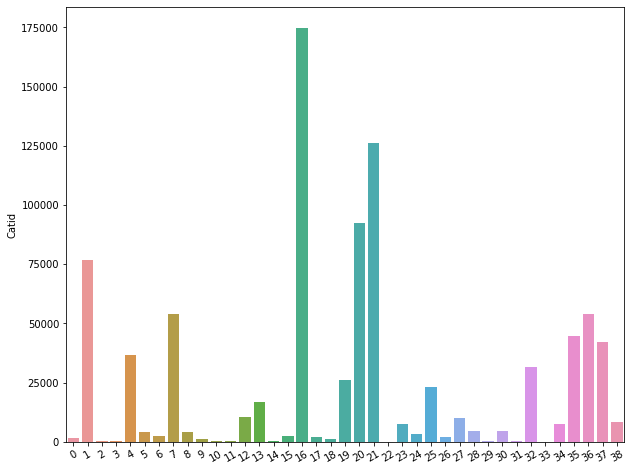

In [130]:
#showing imbalanced target variable distribution
plt.figure(figsize=(10,8))
sb.barplot(df['Catid'].value_counts().index,df['Catid'].value_counts())
plt.xticks(rotation=30)